# Tarea 4. Modelos lineales

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://storage.needpix.com/rsynced_images/bayesian-2889576_1280.png" width="200px" height="180px" />

En esta cuarta tarea, tendrás la oportunidad de estimar una relación cúbica usando un modelo lineal Bayesiano. Para esto usarás los datos en `data/Howell1`, considerando personas de todas las edades.

Por favor, intenta ser lo más explícit@ posible, y en lo posible, apóyate de la escritura matemática con $\LaTeX$.

Recuerda además que ante cualquier duda, me puedes contactar al correo esjimenezro@iteso.mx.

<p style="text-align:right;"> Imagen recuperada de: https://storage.needpix.com/rsynced_images/bayesian-2889576_1280.png.</p>

___

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pymc as pm
import arviz as az

In [2]:
df = pd.read_csv('data/Howell1.csv', sep=';')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Se puede apreciar que el dataset cuenta con altura, peso, edad y sexo. El objetivo sera estimar la relacion cubica entre los datos, incluyendo a personas de todas las edades. 

Existe la variable altura, la cual es el target y se calculara o, mas bien, estimara a partir del peso de cada individuo.

## 1. 

Describir el modelo usando el lenguaje probabilístico visto en clase. Asegurarse, mediante una simulación predictiva previa que las previas son plausibles.

**Ayuda**. Estandarizar el peso antes.

In [3]:
#estandarizamos el peso
df['weight_std'] = (df['weight'] - df['weight'].mean()) / df['weight'].std()
df.head()

,height,weight,age,male,weight_std
0,151.765,47.825606,63.0,1,0.829869
1,139.700,36.485807,63.0,0,0.059459
2,136.525,31.864838,65.0,0,-0.254483
3,156.845,53.041914,41.0,1,1.184257
4,145.415,41.276872,51.0,0,0.384957


Text(0, 0.5, 'altura en cm')

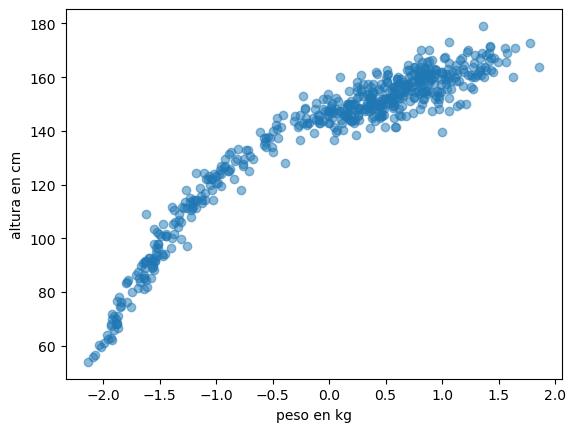

In [4]:
#visualizacion datos
plt.scatter(
    df['weight_std'],
    df['height'],
    alpha=0.5
)
plt.xlabel('peso en kg')
plt.ylabel('altura en cm')

Podemos ver que el peso y la altura tienen una relacion no lineal.
Sea $ w_i $ el peso de la persona $ i $ y sea $ \bar{w} $ el promedio de todos los pesos, se trazará una función de grado 3 para así moldear la altura con los pesos estandarizados:

$h_i \sim \text{Normal}(\mu_i, \sigma)$  

$\mu_i = \alpha + \beta_1 w_i + \beta_2 w_i^2 + \beta_3 w_i^3$  

$\alpha \sim \text{Normal}(140, 20)$

$\beta_1 \sim \text{Log-Normal}(0, 10)$

$\beta_2 \sim \text{Normal}(0, 10)$

$\beta_3 \sim \text{Normal}(0, 10)$

$\sigma \sim \text{Uniform}(0, 40)$


Text(0, 0.5, 'altura en cm')

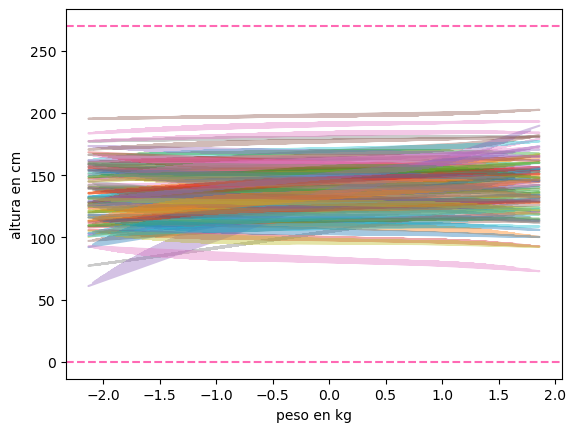

In [18]:
#sim. previa predic.
N = 100
w = np.linspace(
    df['weight_std'].min(),
    df['weight_std'].max(),
)

w = df['weight_std'].values
w_bar = w.mean()

m_alpha = stats.norm.rvs(loc=140, scale=20, size=N)
m_beta1 = stats.lognorm.rvs(loc=0, s=1, size=N)
m_beta2 = stats.norm.rvs(loc=0, scale=1, size=N)
m_beta3 = stats.norm.rvs(loc=0, scale=1, size=N)
m_mu = m_alpha + m_beta1 * (w).reshape(-1, 1) + m_beta2 * ((w)**2).reshape(-1, 1) + m_beta3 * ((w)**3).reshape(-1,1)

plt.plot(df['weight_std'], m_mu, alpha = 0.4)
plt.axhline(y=0,color='hotpink',linestyle='--')
plt.axhline(y=270,color='hotpink',linestyle='--')
plt.xlabel('peso en kg')
plt.ylabel('altura en cm')

## 2.

Encontrar la distribución posterior de los parámetros. ¿Qué puede concluir de cada uno de ellos?

In [11]:
w = df['weight_std'].values

#modelo
with pm.Model() as height_m_predictive:
    sigma = pm.Uniform('sigma', 0 , 50)

    alpha = pm.Normal('alpha', mu=140, sigma=20)
    beta_1 = pm.Lognormal('beta_1', mu = 0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu = 0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu = 0, sigma=1)

    mu = (
        alpha +
        beta_1 * w +
        beta_2 * w**2 +
        beta_3 * w**3)

    altura= pm.Normal(
        'altura',
         mu=mu,
         sigma = sigma,
         observed=df['height'].values
         )
    idata = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_1, beta_2, beta_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


In [12]:
#dist post de los parametros
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,146.382,0.307,145.818,146.975,0.006,0.004,2534.0,2302.0,1.0
beta_2,-6.190,0.254,-6.681,-5.729,0.005,0.004,2425.0,2531.0,1.0
beta_3,3.588,0.225,3.160,3.994,0.005,0.003,2351.0,2603.0,1.0
sigma,4.861,0.149,4.570,5.123,0.003,0.002,3186.0,2570.0,1.0
beta_1,15.215,0.473,14.348,16.116,0.009,0.007,2513.0,2358.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'beta_1'}>, <Axes: >]], dtype=object)

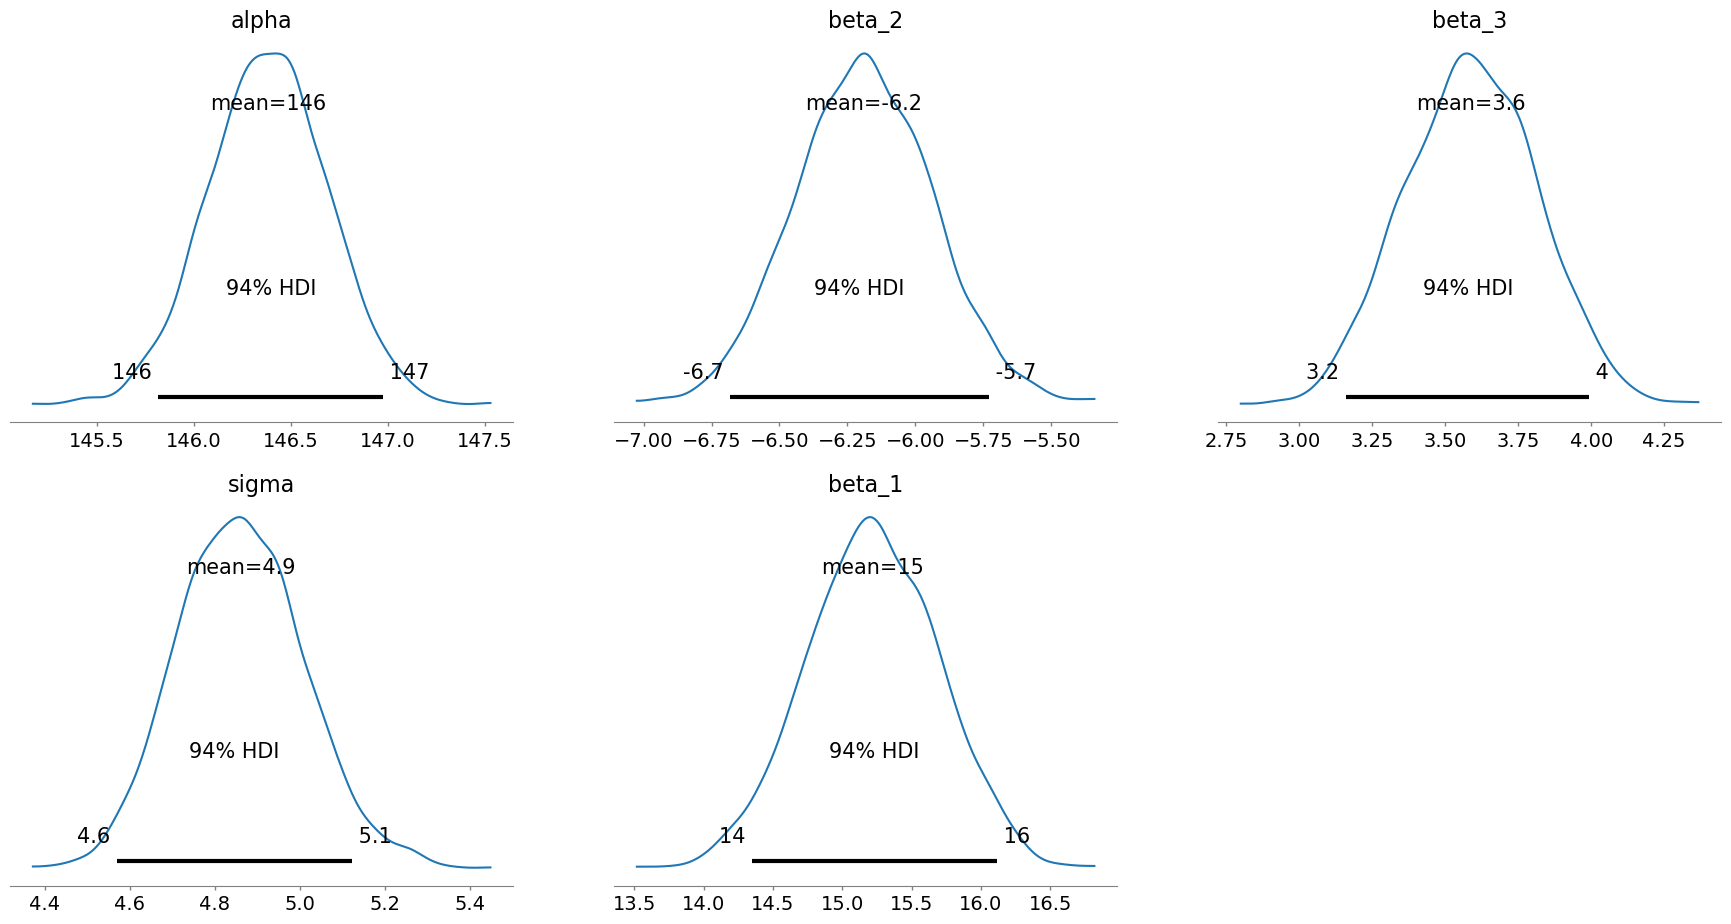

In [13]:
az.plot_posterior(idata)

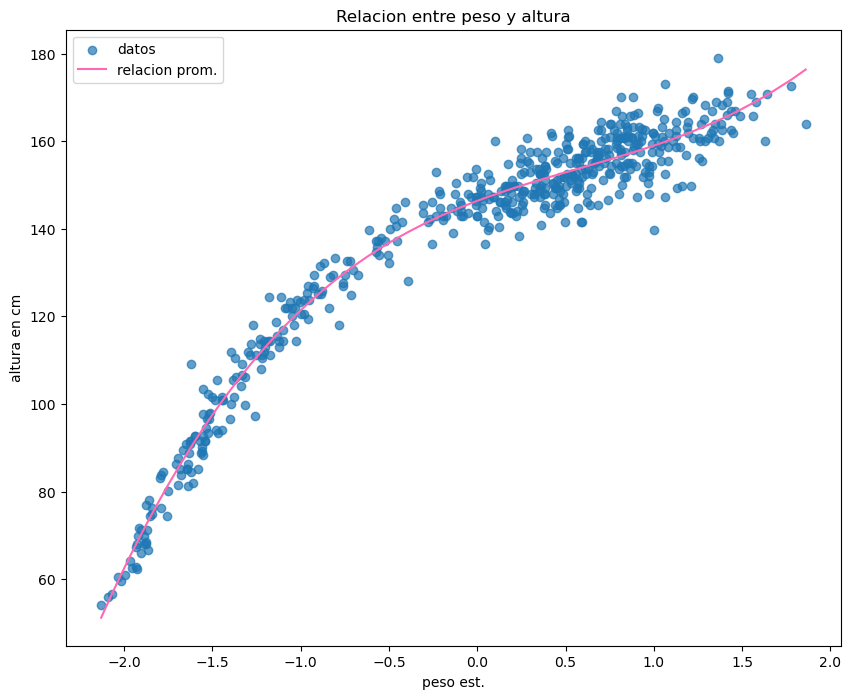

In [17]:
w_s = np.sort(w)

alpha_avg = idata.posterior['alpha'].mean().item()
beta_1_avg = idata.posterior['beta_1'].mean().item()
beta_2_avg = idata.posterior['beta_2'].mean().item()
beta_3_avg = idata.posterior['beta_3'].mean().item()

mu_avg = (alpha_avg + beta_1_avg * w_s + beta_2_avg * w_s**2 + beta_3_avg * w_s**3)

plt.figure(figsize=(10,8))
plt.scatter(
    df['weight_std'],
    df['height'],
    alpha=0.7,
    label = 'datos'
)
plt.plot(w_s, mu_avg, color='hotpink', label='relacion prom.')
plt.xlabel('peso est.')
plt.ylabel('altura en cm')
plt.legend()
plt.title('Relacion entre peso y altura')
plt.show()

El modelo se ajusta de manera adecuada a los datos :)

## 3.

¿Cuál es la distribución de la altura promedio de un infante de 10kg según tu modelo y los datos?

In [19]:
post_df = idata.posterior.to_dataframe()
post_df.head()

alpha    beta_2    beta_3     sigma     beta_1
chain draw                                                     
0     0     146.023466 -6.371392  3.218965  5.164667  15.957645
      1     146.159683 -6.226401  3.252454  5.142724  15.813562
      2     146.365219 -6.194514  3.249043  5.118905  16.096589
      3     146.167680 -6.251482  3.383691  4.687605  15.976697
      4     146.190445 -6.242849  3.368768  4.782244  15.472010

In [20]:
w_10 = (10 -df['weight'].mean()) / df['weight'].std()
mu_10 = (
    post_df['alpha'].values +
    post_df['beta_1'].values * w_10 +
    post_df['beta_2'].values * (w_10**2) +
    post_df['beta_3'].values * (w_10**3))
mu_10.shape

(4000,)

In [21]:
mu_10.mean(), np.percentile(mu_10, 3), np.percentile(mu_10, 97)

(82.26640002985322, 81.28697556752367, 83.25348277841)

<Axes: >

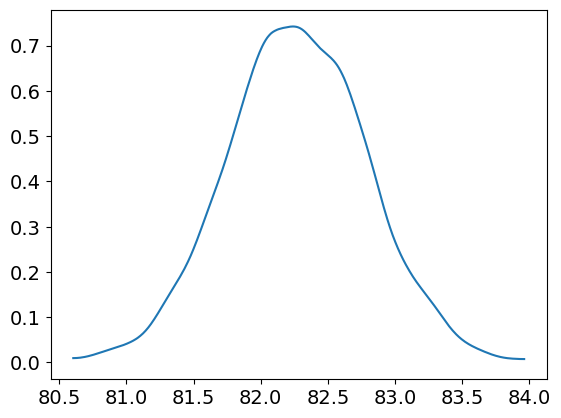

In [22]:
az.plot_kde(mu_10)

El promedio de latura para una persona de 10kg seria entre 81 y 83.5 cm

## 4.

Graficar:

- El intervalo de credibilidad al 89% de la altura para cada peso.
- El intervalo de credibilidad al 89% de la altura promedio para cada peso.
- La altura promedio para cada peso.
- Los puntos correspondientes a cada individuo.

Text(0, 0.5, 'altura en cm')

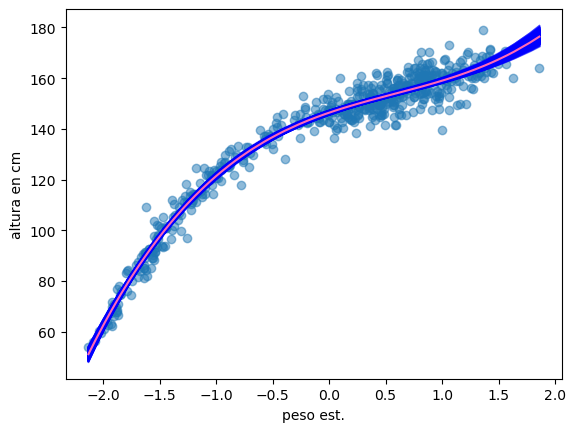

In [23]:
m_post = post_df.sample(544)
post_mu = (m_post['alpha'].values +
           m_post['beta_1'].values * ((w_s).reshape(-1,1)) +
           m_post['beta_2'].values * ((w_s**2).reshape(-1,1)) +
           m_post['beta_3'].values * ((w_s**3).reshape(-1,1))
           )
plt.scatter(
    df['weight_std'],
    df['height'],
    alpha=0.5
)

plt.plot(w_s, post_mu, color='blue', alpha=0.5)
plt.plot(w_s, mu_avg, color='hotpink')
plt.xlabel('peso est.')
plt.ylabel('altura en cm')

In [24]:
with height_m_predictive:
    height_post_predictive = pm.sample_posterior_predictive(idata)

Sampling: [altura]


c:\Users\sarah\anaconda3\envs\mebo2024_v4\lib\site-packages\arviz\plots\hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


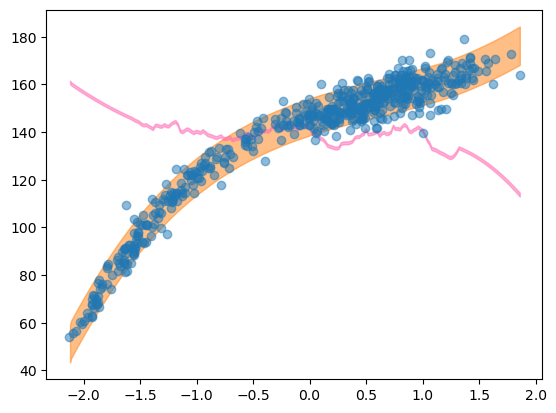

In [25]:
az.plot_hdi(w, height_post_predictive.posterior_predictive['altura'], hdi_prob=0.89)
az.plot_hdi(w, post_mu.T, color='hotpink', hdi_prob=0.89)

plt.scatter(
    df['weight_std'],
    df['height'],
    alpha=0.5
)

Vemos que el modelo funciono correctamente 👌

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>